# Image Alignment
**Satya Mallick, LearnOpenCV.com**

## Align an image to a template.
![alt text](https://learnopencv.com/wp-content/uploads/2023/03/opencv_bootcamp_08_image-alignment-using-opencv.jpg "Image Alignment")

## Theory

1. A **Homography** transforms a square to arbitrary quad.

![alt text](https://learnopencv.com/wp-content/uploads/2023/03/opencv_bootcamp_08_motion-models.jpg "Motion Models")

## Theory

2. Images of two planes are related by a **Homography**
3. We need **4 corresponding points** to estimate Homography


!["Homography Example"](https://learnopencv.com/wp-content/uploads/2023/03/opencv_bootcamp_08_homography-example.jpg)

In [1]:
# Imports
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile
from urllib.request import urlretrieve

%matplotlib inline

##  <font style="color:black">Download Assets</font>

In [2]:
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assests....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)

In [3]:
URL = r"https://www.dropbox.com/s/zuwnn6rqe0f4zgh/opencv_bootcamp_assets_NB8.zip?dl=1"

asset_zip_path = os.path.join(os.getcwd(), "opencv_bootcamp_assets_NB8.zip")

# Download if assest ZIP does not exists.
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)

## Step 1: Read Template and Scanned Image

In [4]:
# Read reference image
refFilename = "form.jpg"
print("Reading reference image:", refFilename)
im1 = cv2.imread(refFilename, cv2.IMREAD_COLOR)
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)

# Read image to be aligned
imFilename = "scanned-form.jpg"
print("Reading image to align:", imFilename)
im2 = cv2.imread(imFilename, cv2.IMREAD_COLOR)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)

Reading reference image: form.jpg
Reading image to align: scanned-form.jpg


Text(0.5, 1.0, 'Scanned Form')

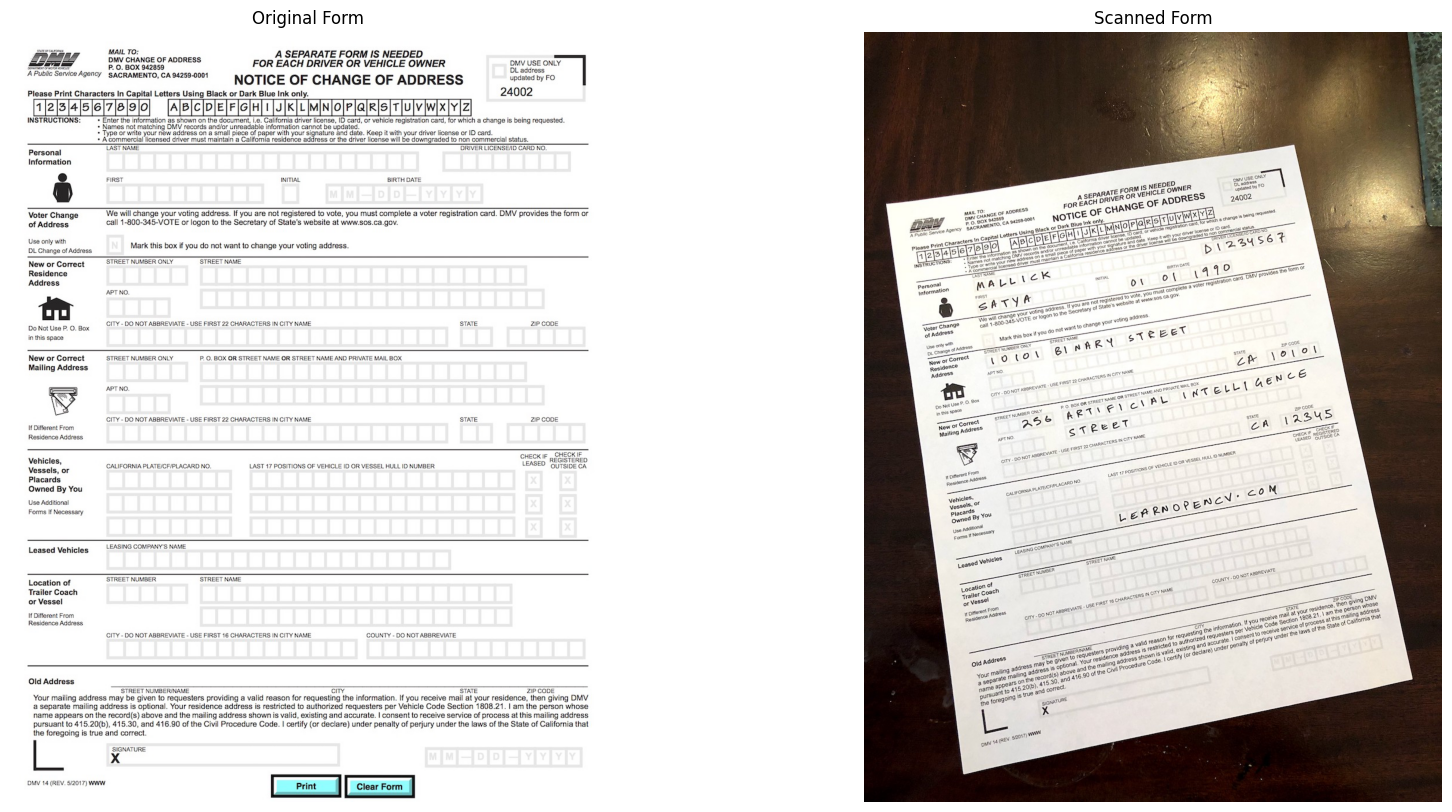

In [5]:
# Display Images

plt.figure(figsize=[20, 10]);
plt.subplot(121); plt.axis('off'); plt.imshow(im1); plt.title("Original Form")
plt.subplot(122); plt.axis('off'); plt.imshow(im2); plt.title("Scanned Form")

## Step 2: Find keypoints in both Images

Think of keypoints as corner points that are stable under image transformations

ORB (Oriented FAST and Rotated BRIEF) adalah suatu metode dalam pengolahan citra yang digunakan untuk mengekstraksi fitur (feature) dari gambar. Fitur-fitur ini digunakan dalam algoritma homografi untuk mencocokkan titik-titik penting antara dua gambar yang ingin di-transformasi.

Keypoint (Titik Penting):
- Titik penting atau keypoint adalah posisi khusus di dalam gambar yang dianggap "menonjol" atau "menarik perhatian".
- Titik-titik penting ini biasanya mewakili sudut, tepi, atau bagian penting lainnya dari objek dalam gambar.
- ORB menggunakan modifikasi dari algoritma FAST (Features from Accelerated Segment Test) untuk mendeteksi titik-titik penting dengan cepat dan efisien.
- Selain itu, ORB juga dapat menghitung orientasi atau arah dari setiap titik penting untuk meningkatkan kekuatan dan keandalan fitur.

Descriptor (Deskriptor):
- Deskriptor adalah representasi numerik atau vektor yang menggambarkan ciri-ciri lokal pada titik penting.
- ORB menggunakan metode BRIEF (Binary Robust Independent Elementary Features) yang menghasilkan deskriptor biner yang singkat untuk setiap titik penting.
- Deskriptor ini mencerminkan karakteristik unik dari wilayah sekitar titik penting, seperti pola intensitas piksel dan distribusi tekstur lokal.
- Deskriptor ORB memiliki sifat yang tahan terhadap rotasi, sehingga lebih baik dalam mengatasi perubahan sudut pandang dan rotasi objek.

Dalam algoritma ORB, proses berikut terjadi:
1. Deteksi titik-titik penting di gambar menggunakan metode FAST yang dimodifikasi.
2. Penghitungan orientasi untuk setiap titik penting.
3. Ekstraksi deskriptor biner yang singkat untuk setiap titik penting menggunakan metode BRIEF.

In [6]:
# Convert images to grayscale
im1_gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
im2_gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

# Detect ORB features and compute descriptors.
MAX_NUM_FEATURES = 500
orb = cv2.ORB_create(MAX_NUM_FEATURES)
keypoints1, descriptors1 = orb.detectAndCompute(im1_gray, None)
keypoints2, descriptors2 = orb.detectAndCompute(im2_gray, None)

# Display
im1_display = cv2.drawKeypoints(im1, keypoints1, outImage=np.array([]),
                                color=(255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
im2_display = cv2.drawKeypoints(im2, keypoints2, outImage=np.array([]),
                                color=(255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

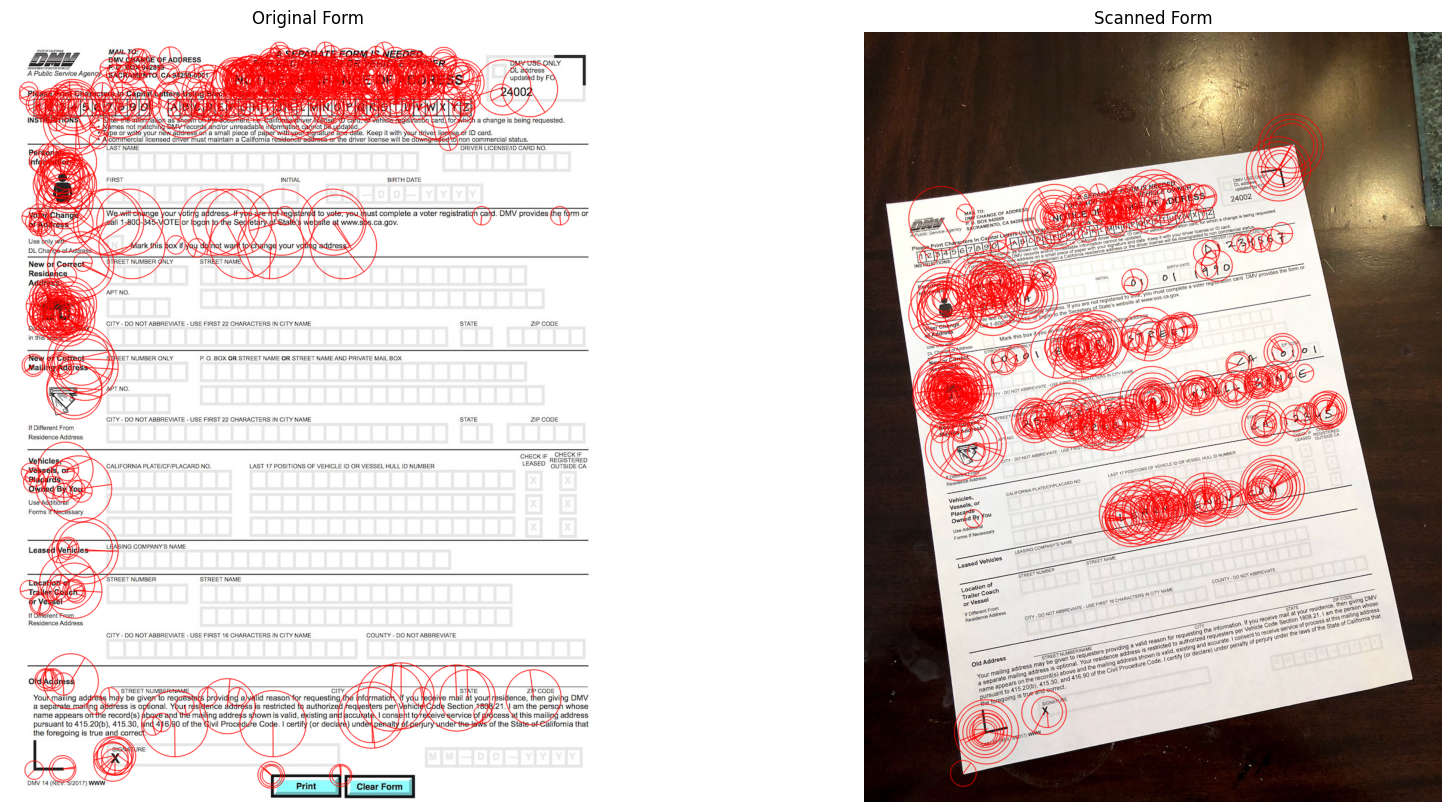

In [7]:
plt.figure(figsize=[20,10])
plt.subplot(121); plt.axis('off'); plt.imshow(im1_display); plt.title("Original Form");
plt.subplot(122); plt.axis('off'); plt.imshow(im2_display); plt.title("Scanned Form");

## Step 3 : Match keypoints in the two image

Pencocokan fitur (feature matching) antara dua gambar menggunakan algoritma ORB dan metode pencocokan Brute-Force dengan metrik Hamming.

In [8]:
# Match features.
# Membuat objek matcher untuk melakukan pencocokan fitur. Dalam contoh ini, metode pencocokan yang digunakan adalah Brute-Force dengan metrik Hamming. Algoritma Brute-Force akan membandingkan setiap deskriptor fitur pada gambar pertama dengan setiap deskriptor fitur pada gambar kedua secara berurutan.
matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)

# Converting to list for sorting as tuples are immutable objects.
# Melakukan pencocokan fitur antara dua set deskriptor fitur (descriptors1 dan descriptors2) menggunakan objek matcher yang telah dibuat sebelumnya.
matches = list(matcher.match(descriptors1, descriptors2, None))

# Sort matches by score
# Mengurutkan hasil pencocokan (matches) berdasarkan skor pencocokan (distance) terdekat
matches.sort(key=lambda x: x.distance, reverse=False)

# Remove not so good matches
# mengambil 10 persen hasil dengan jarak terdekat saja
numGoodMatches = int(len(matches) * 0.1)
matches = matches[:numGoodMatches]

Text(0.5, 1.0, 'Original Form')

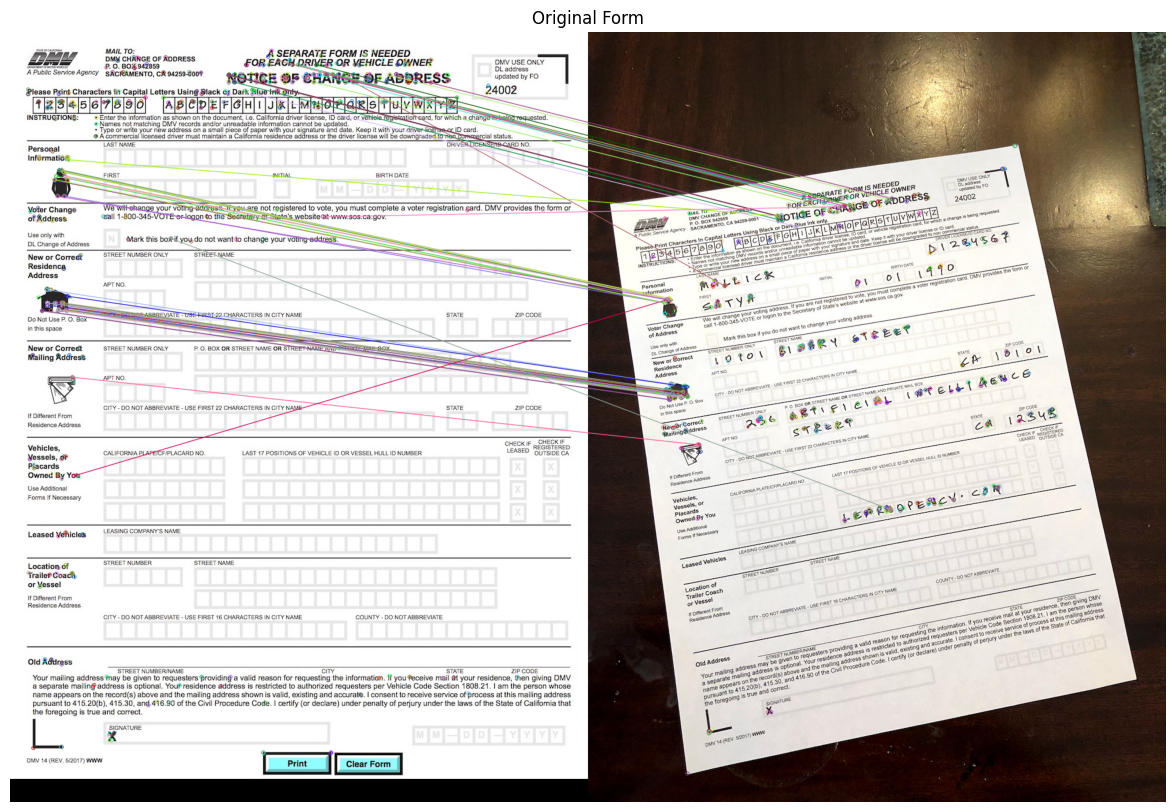

In [9]:
# Draw top matches
im_matches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)

plt.figure(figsize=[40, 10])
plt.imshow(im_matches);plt.axis("off");plt.title("Original Form")

## Step 4:  Find Homography



Lanjutan dari proses pencocokan fitur (feature matching) antara dua gambar menggunakan algoritma ORB dan metode pencocokan Brute-Force dengan metrik Hamming, serta digunakan untuk mencari homografi antara dua gambar.

In [10]:
# Extract location of good matches
# Membuat array dengan ukuran sesuai matches
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    # mengambil titik penting dari gambar pertama dan kedua
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt

# Find homography
# Melakukan estimasi homografi berdasarkan posisi titik-titik penting yang cocok di kedua gambar (points2 dan points1).
h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

## Step 5: Warp image

Text(0.5, 1.0, 'Scanned Form')

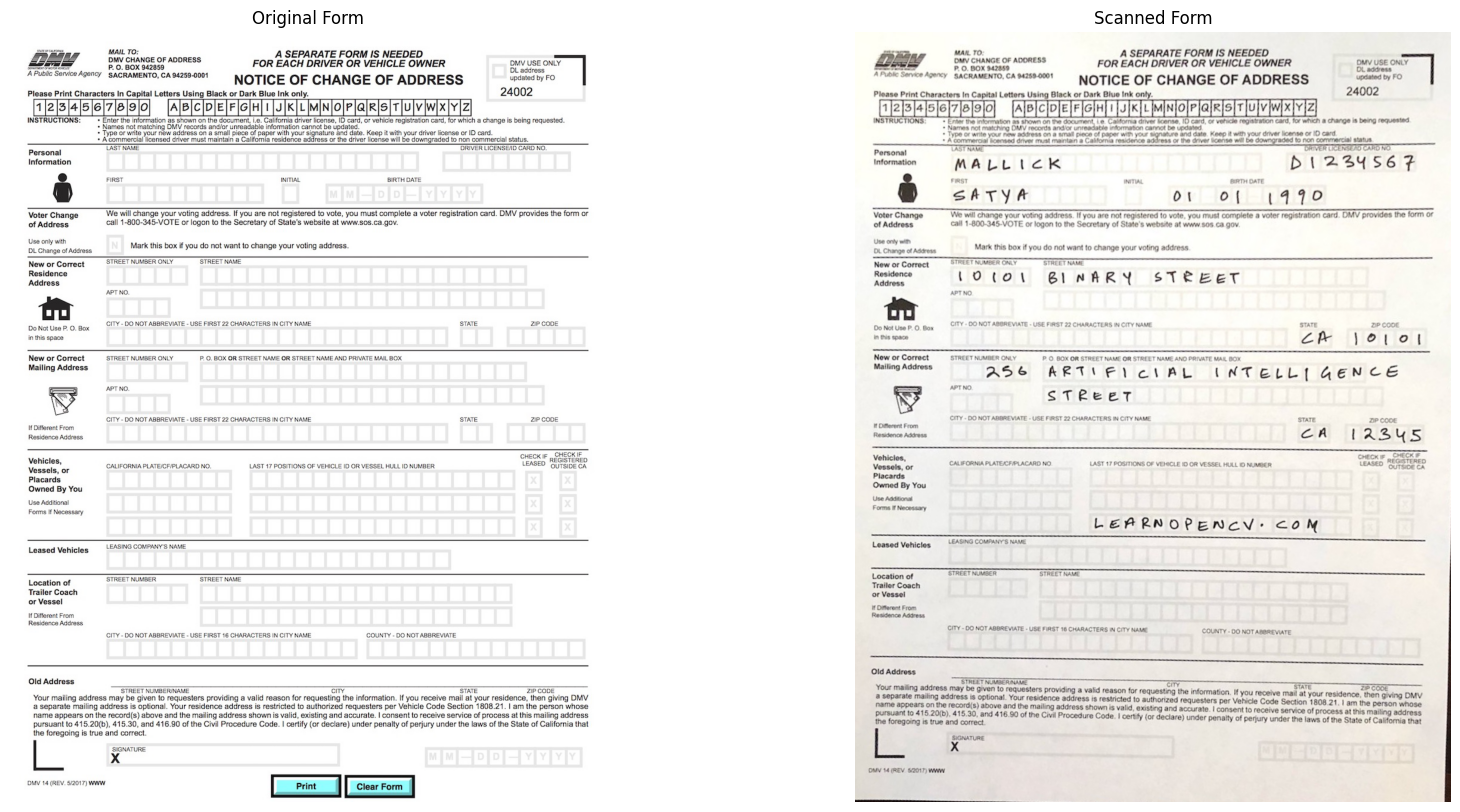

In [11]:
# Use homography to warp image
height, width, channels = im1.shape

# melakukan transformasi perspektif pada gambar kedua (im2) berdasarkan homografi h yang telah diperoleh sebelumnya
im2_reg = cv2.warpPerspective(im2, h, (width, height))

# Display results
plt.figure(figsize=[20, 10])
plt.subplot(121);plt.imshow(im1);    plt.axis("off");plt.title("Original Form")
plt.subplot(122);plt.imshow(im2_reg);plt.axis("off");plt.title("Scanned Form")

## Alur Image Alignment
1. **Load Image**: Baca dua gambar yang akan di-align dari sumber yang ada, misalnya dari file atau kamera.
2. **Convert to Grayscale**: Ubah kedua gambar menjadi citra grayscale. Ini diperlukan karena algoritma ORB memerlukan citra grayscale untuk proses ekstraksi fitur
3. **Detect Keypoints and Compute Descriptors**: Gunakan algoritma ORB untuk mendeteksi titik-titik penting (keypoints) dan menghitung deskriptornya pada kedua gambar. ORB akan memberikan daftar keypoints dan deskriptor yang menggambarkan ciri-ciri dari setiap titik penting.
4. **Feature Matching**: Cocokkan fitur-fitur (keypoints dan deskriptor) antara kedua gambar. Metode pencocokan yang umum digunakan adalah Brute-Force dengan metrik Hamming untuk ORB.
5. **Filtering Matches**: Sortir hasil pencocokan berdasarkan tingkat kesesuaiannya (distance/skor). Terkadang, kita hanya tertarik pada fitur-fitur yang sangat cocok (good matches) yang memiliki jarak terdekat di antara nilai pencocokan.
6. **Extract Corresponding Points**: Ambil posisi (koordinat) dari titik-titik penting yang cocok (good matches) pada kedua gambar.
7. **Compute Homography**: Hitung homografi yang menghubungkan dua gambar berdasarkan titik-titik penting yang cocok yang telah diekstraksi sebelumnya. Homografi ini merepresentasikan transformasi perspektif yang diperlukan untuk mengubah posisi salah satu gambar agar sesuai dengan posisi gambar lainnya.
8. **Warp Image**: Gunakan homografi yang telah ditemukan untuk melakukan transformasi perspektif pada salah satu gambar sehingga sesuai dengan posisi gambar yang lain.
9. **Display Results**: Tampilkan kedua gambar yang telah di-align atau hasil transformasi pada layar, sehingga kita dapat membandingkan gambar-gambar tersebut.
10. **Further Processing (Optional)**: Hasil image alignment dengan homografi dapat digunakan untuk berbagai tujuan seperti penggabungan gambar panoramic, augmented reality, atau deteksi objek.